In [72]:
# Install xgboost in notebook instance.
!pip install xgboost==1.2
!pip install imbalanced-learn==0.9.1

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [73]:
# Import required dependencies
import boto3
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb_lib
from sklearn.linear_model import LogisticRegression

import sklearn

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter
import shap

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

In [74]:
# Readind data
bucket_name = 'finance-factoring-ml-dev'

df = pd.read_csv('s3://{}/data/all.csv'.format(bucket_name))
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,FechaPago
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,1939.0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,1638.0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,1551.0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,2226.0
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,2166.0


In [75]:
# Remove RFC Columns
df.drop("RFCPagador", axis=1, inplace=True)
df.drop("Moneda", axis=1, inplace=True)
df.drop("DepositoInicial", axis=1, inplace=True)
df.drop("Intereses", axis=1, inplace=True)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago
0,1918.0,0,1953.0,38879.48,1939.0
1,1634.0,1,1654.0,6658.40,1638.0
2,1583.0,2,1551.0,791.12,1551.0
3,2282.0,3,2225.0,33048.00,2226.0
4,2110.0,4,2170.0,424634.82,2166.0


## Build aggregate features from historical data

In [76]:
# today = datetime.now()
# current_date = date.today()

# future_date = current_date - relativedelta(months=window_size)

# today = (future_date - date(2016, 1, 1)) 
# print(today)

# datetime(2016, 1, 1)
# print(dt.strftime('%Y%m%d'))

# today = today.strftime("%Y-%m-%d %H:%M:%S")
# print(datetime.strptime(today, "%Y-%m-%d %H:%M:%S"))
# today = (datetime.strptime(today, "%Y-%m-%d %H:%M:%S") - datetime(2016, 1, 1)) / np.timedelta64(1, 'D')
# print("2022:", today)
# print(datetime(2016, 1, 1))

def calc_time_range(input_days):
    window_size = 4
    origin = date(2016,1,1)

    invoice_date = origin + relativedelta(days=input_days)
    minimun_date = invoice_date - relativedelta(months=window_size)    
    minimun_date = minimun_date - origin

    return minimun_date.days


In [82]:
# Build feature Number of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha))]
    
    return len(df_filtered.index)

df['NumberTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.181818
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000


In [83]:
# Build feature Number of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > df.FechaVencimiento)]
    
    return len(df_filtered.index)

df['NumberInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.181818
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000


In [84]:
# Build feature Ratio of paid invoices that were late
def calc_delta(row):
    if row.NumberTotalPaidInvoices == 0:
        return 0
    else:
        return row.NumberInvoicesPaidLate / row.NumberTotalPaidInvoices

df['RatioInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000


In [85]:
# Build feature Sum of the base amount of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha))]
    
    return df_filtered.Monto.sum()

df['SumAmountTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78


In [86]:
# Build feature Sum of the base amount of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > df.FechaVencimiento)]
    
    return df_filtered.Monto.sum()

df['SumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00


In [87]:
# Build feature Ratio of sum of paid base amount that were late
def calc_delta(row):
    if row.SumAmountTotalPaidInvoices == 0:
        return 0
    else:
        return row.SumAmountInvoicesPaidLate / row.SumAmountTotalPaidInvoices

df['RatioSumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000


In [88]:
# Build feature Average days late of paid invoices being late.
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > df.FechaVencimiento)]
  
    df_filtered['DaysLate'] = df_filtered['FechaPago'] - df_filtered['FechaVencimiento']
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,3.714286
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000


In [89]:
# Build feature Number of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > row.Fecha)]
  
    return len(df_filtered.index)

df['NumberTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000,20
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000,10
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,3.714286,36
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000,0


In [90]:
# Build feature Number of outstanding invoices that were already late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > df.FechaVencimiento) & (df.FechaPago > row.Fecha)]
  
    return len(df_filtered.index)

df['NumberOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000,20,10
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000,10,0
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,3.714286,36,6
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000,0,0


In [91]:
# Build feature Ratio of outstanding invoices that were late
def calc_delta(row):
    if row.NumberTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.NumberOutstandingLateInvoices / row.NumberTotalOutstandingInvoices

df['RatioOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000,20,10,0.500000
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000,10,0,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,3.714286,36,6,0.166667
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000,0,0,0.000000


In [92]:
# Build feature Sum of the base amount of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > row.Fecha)]
  
    return df_filtered.Monto.sum()

df['SumAmountTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000,20,10,0.500000,510099.33
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000,10,0,0.000000,331133.60
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,3.714286,36,6,0.166667,1097807.95
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000,0,0,0.000000,0.00


In [93]:
# Build feature Sum of the base amount of outstanding invoices that were late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > row.Fecha) & (df.FechaPago > df.FechaVencimiento)]
  
    return df_filtered.Monto.sum()

df['SumAmountOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000,20,10,0.500000,510099.33,249381.40
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000,10,0,0.000000,331133.60,0.00
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,3.714286,36,6,0.166667,1097807.95,549081.45
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00


In [94]:
# Build feature Ratio of sum of outstanding base amount that were late
def calc_delta(row):
    if row.SumAmountTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.SumAmountOutstandingLateInvoices / row.SumAmountTotalOutstandingInvoices

df['RatioSumAmountOutstandingLateInvoice'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000,20,10,0.500000,510099.33,249381.40,0.488888
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000,10,0,0.000000,331133.60,0.00,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,3.714286,36,6,0.166667,1097807.95,549081.45,0.500162
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000


In [95]:
# Build feature Average days late of outstanding invoices being late.
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.Fecha >= calc_time_range(row.Fecha)) & (df.FechaPago > df.FechaVencimiento) & (df.FechaPago > row.Fecha)]
  
    df_filtered['DaysLate'] = df_filtered['FechaPago'] - df_filtered['FechaVencimiento']
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice
0,1918.0,0,1953.0,38879.48,1939.0,36,10,0.277778,904735.84,249381.40,0.275640,19.400000,20,10,0.500000,510099.33,249381.40,0.488888
1,1634.0,1,1654.0,6658.40,1638.0,10,0,0.000000,331133.60,0.00,0.000000,0.000000,10,0,0.000000,331133.60,0.00,0.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,78,14,0.179487,2500539.89,989672.85,0.395784,4.333333,36,6,0.166667,1097807.95,549081.45,0.500162
4,2110.0,4,2170.0,424634.82,2166.0,8,0,0.000000,1938205.78,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000


# 5. Prepare dataframes for modeling approaches

Build temporary **DaysLate** column

In [103]:
def calc_delta(row):
    days = (row['FechaPago'] - row['FechaVencimiento'])
    return days if days > 0 else 0

df['DaysLate'] = df.apply(calc_delta, axis=1)

# Remove "FechaPago" and RFCCliente features
df.drop("FechaPago", axis=1, inplace=True)
df.drop("RFCCliente", axis=1, inplace=True)

df.head()

KeyError: 'FechaPago'

TODO
Build target column **PaidTime**
> * 1: On time
> * 2: Late payment 1-30 days
> * 3: Late payment 31-60 days
> * 4: Late payment 61-90 days
> * 5: Late payment > 90 days

In [104]:
def build_paidTime(row):
    if row.DaysLate == 0:
        return 1
    if row.DaysLate <= 30:
        return 2
    if row.DaysLate <= 60:
        return 3
    if row.DaysLate <= 90:
        return 4
    else:
        return 5

df['PaidTime'] = df.apply(build_paidTime, axis=1)

df.head()

AttributeError: 'Series' object has no attribute 'DaysLate'

In [105]:
# Remove "DaysLate" because it's not gonna be needed anymore
df.drop("DaysLate", axis=1, inplace=True)
df.head()

KeyError: "['DaysLate'] not found in axis"

Separate target for predictions

In [106]:
X = df.drop(['PaidTime'], axis=1)
y = df.PaidTime

In [107]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (14966, 16)
Test dataset shape:  (3742, 16)


In [108]:
# Helper function to plot confusion matrix
def render_confusion_matrix(y_test_input, predicted, clasess):
    ac_s = accuracy_score(y_test_input, predicted)
    print('The Accuracy is: ', int(ac_s * 100), " %")

    cm = confusion_matrix(y_test_input, predicted, labels=clasess)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasess)
    disp.plot()
    return ac_s

In [109]:
# Helper function to plot models accuracies
def plot_models_accuracy(models_name, accuracies):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(models_name,accuracies)
    _ = plt.xticks(rotation=90,fontsize=14)
    plt.title('Compare accuracy (test)')
    plt.ylim(0.30, 1.0)
    plt.show()   

## 5.1 Decision Tree Classifier

The Accuracy is:  87  %


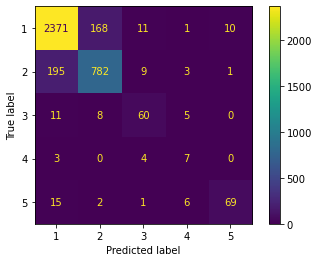

In [117]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

predicted_tree = tree.predict(X_test)

ac_simple = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

## Feature Importance

Feature: 0, Score: 0.04445
Feature: 1, Score: 0.22019
Feature: 2, Score: 0.14002
Feature: 3, Score: 0.04663
Feature: 4, Score: 0.03934
Feature: 5, Score: 0.13873
Feature: 6, Score: 0.04588
Feature: 7, Score: 0.02937
Feature: 8, Score: 0.03815
Feature: 9, Score: 0.03495
Feature: 10, Score: 0.02794
Feature: 11, Score: 0.03274
Feature: 12, Score: 0.06091
Feature: 13, Score: 0.04312
Feature: 14, Score: 0.02655
Feature: 15, Score: 0.03101


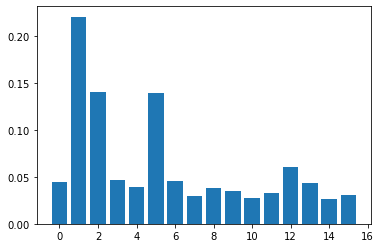

Index(['Fecha', 'FechaVencimiento', 'Monto', 'NumberTotalPaidInvoices',
       'NumberInvoicesPaidLate', 'RatioInvoicesPaidLate',
       'SumAmountTotalPaidInvoices', 'SumAmountInvoicesPaidLate',
       'RatioSumAmountInvoicesPaidLate', 'AvgDaysLateInvoicesPaidLate',
       'NumberTotalOutstandingInvoices', 'NumberOutstandingLateInvoices',
       'RatioOutstandingLateInvoices', 'SumAmountTotalOutstandingInvoices',
       'SumAmountOutstandingLateInvoices',
       'RatioSumAmountOutstandingLateInvoice', 'PaidTime'],
      dtype='object')


In [115]:
# get importance
importance = tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

print(df.columns)

## 5.2 XGBoost Classifier

The Accuracy is:  88  %


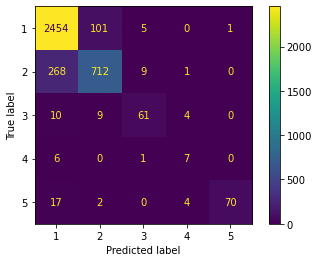

In [116]:
xgb = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    max_depth=3,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    verbosity=0,
                    use_label_encoder=False)

xgb = xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)

ac_simple = render_confusion_matrix(y_test, predicted_xgb, xgb.classes_)

Feature: 0, Score: 0.03901
Feature: 1, Score: 0.07320
Feature: 2, Score: 0.01439
Feature: 3, Score: 0.08799
Feature: 4, Score: 0.05410
Feature: 5, Score: 0.22537
Feature: 6, Score: 0.04560
Feature: 7, Score: 0.03538
Feature: 8, Score: 0.06444
Feature: 9, Score: 0.03532
Feature: 10, Score: 0.04476
Feature: 11, Score: 0.05466
Feature: 12, Score: 0.13171
Feature: 13, Score: 0.03081
Feature: 14, Score: 0.03579
Feature: 15, Score: 0.02749


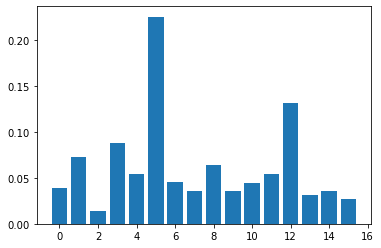

Index(['Fecha', 'FechaVencimiento', 'Monto', 'NumberTotalPaidInvoices',
       'NumberInvoicesPaidLate', 'RatioInvoicesPaidLate',
       'SumAmountTotalPaidInvoices', 'SumAmountInvoicesPaidLate',
       'RatioSumAmountInvoicesPaidLate', 'AvgDaysLateInvoicesPaidLate',
       'NumberTotalOutstandingInvoices', 'NumberOutstandingLateInvoices',
       'RatioOutstandingLateInvoices', 'SumAmountTotalOutstandingInvoices',
       'SumAmountOutstandingLateInvoices',
       'RatioSumAmountOutstandingLateInvoice', 'PaidTime'],
      dtype='object')


In [113]:
# get importance
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

print(df.columns)